#**NEURAL MACHINE TRANSLATION USING ENCODER DECODER ATTENTION MODEL**
# Translating from English to Spanish

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import preprocessing, utils
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Downloading dataset for Spanish to English translation

In [ ]:
!pip install wget
import wget 
url = 'https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch08/spa.txt'
wget.download(url,'spa.txt')

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=a8f21b152142e01b96548d9f0055d59d4e44eb3029e1a66146bf9dd31b2bc2e2
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


'spa.txt'

# Creating datasets for training 

In [ ]:
# reading data
with open('/content/spa.txt',encoding='utf-8',errors='ignore') as file:
  text=file.read().split('\n')

In [ ]:
len(text)

122937

In [ ]:
text[:5] # input and target data is separated by tab '\t'

['Go.\tVe.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)',
 'Go.\tVete.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)',
 'Go.\tVaya.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)',
 'Go.\tVáyase.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)',
 'Hi.\tHola.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)']

In [ ]:
for t in text[100:110]:
  print(t)

Be good.	Sed buenas.	CC-BY 2.0 (France) Attribution: tatoeba.org #7932304 (Seael) & #7932308 (Seael)
Be good.	Sed buenos.	CC-BY 2.0 (France) Attribution: tatoeba.org #7932304 (Seael) & #7932309 (Seael)
Be good.	Sea buena.	CC-BY 2.0 (France) Attribution: tatoeba.org #7932304 (Seael) & #7932310 (Seael)
Be good.	Sea bueno.	CC-BY 2.0 (France) Attribution: tatoeba.org #7932304 (Seael) & #7932311 (Seael)
Be good.	Sean buenas.	CC-BY 2.0 (France) Attribution: tatoeba.org #7932304 (Seael) & #7932313 (Seael)
Be good.	Sean buenos.	CC-BY 2.0 (France) Attribution: tatoeba.org #7932304 (Seael) & #7932315 (Seael)
Be kind.	Sean gentiles.	CC-BY 2.0 (France) Attribution: tatoeba.org #1916315 (CK) & #2092229 (hayastan)
Be nice.	Sé agradable.	CC-BY 2.0 (France) Attribution: tatoeba.org #1916314 (CK) & #5769224 (arh)
Beat it.	Pírate.	CC-BY 2.0 (France) Attribution: tatoeba.org #37902 (CM) & #5769215 (arh)
Call me.	Llamame.	CC-BY 2.0 (France) Attribution: tatoeba.org #1553532 (CK) & #1555788 (hayastan)


In [ ]:
input_texts=[] #encoder input
target_texts=[] # decoder input

In [ ]:
# we will select subset of the whole data
NUM_SAMPLES = 10000 
for line in text[:NUM_SAMPLES]:
  english, spanish  = line.split('\t')[:2]
  target_text = spanish.lower()
  input_texts.append(english.lower())
  target_texts.append(target_text)

In [ ]:
print(input_texts[:5],target_texts[:5]) 

['go.', 'go.', 'go.', 'go.', 'hi.'] ['ve.', 'vete.', 'vaya.', 'váyase.', 'hola.']


# Data processing

In [ ]:
import string
print('Characters to be removed in preprocessing', string.punctuation)

Characters to be removed in preprocessing !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
#removing punctuation from target and input
def remove_punctuation(s):
  out=s.translate(str.maketrans("","",string.punctuation))
  return out

In [ ]:
input_texts = [remove_punctuation(s) for s in input_texts]
target_texts = [remove_punctuation(s) for s in target_texts]

In [ ]:
input_texts[:5],target_texts[:5]

(['go', 'go', 'go', 'go', 'hi'], ['ve', 'vete', 'vaya', 'váyase', 'hola'])

In [ ]:
# adding start and end tags
target_texts=['<start> ' + s + ' <end>' for s in target_texts] 

In [ ]:
target_texts[1]

'<start> vete <end>'

# Tokenizing Input dataset

In [ ]:
tokenizer_in=Tokenizer()
#tokenizing the input texts
tokenizer_in.fit_on_texts(input_texts) 
#vocab size of input
input_vocab_size=len(tokenizer_in.word_index) + 1  

In [ ]:
input_vocab_size

2332

In [ ]:
# Listing few items
input_tokens = tokenizer_in.index_word
for k,v in sorted(input_tokens.items())[2000:2010]:
    print (k,v)

2001 sauce
2002 doctors
2003 plenty
2004 usually
2005 credible
2006 hopeless
2007 starving
2008 concept
2009 country
2010 thought


# Tokenizing Output dataset

In [ ]:
#tokenizing output that is spanish translation
tokenizer_out=Tokenizer(filters='') 
tokenizer_out.fit_on_texts(target_texts) 
#vocab size of output
output_vocab_size=len(tokenizer_out.word_index) + 1  
output_vocab_size

4964

In [ ]:
# Listing few items
output_tokens = tokenizer_out.index_word
for k,v in sorted(output_tokens.items())[2000:2010]:
    print (k,v)

2001 suyos
2002 ley
2003 palabras
2004 ausente
2005 delgaducho
2006 sucio
2007 adoptado
2008 violento
2009 roncando
2010 podríamos


#Creating input sequences

In [ ]:
#converting tokenized sentence into sequences
tokenized_input = tokenizer_in.texts_to_sequences( input_texts ) 
#max length of the input
maxlen_input = max( [ len(x) for x in tokenized_input ] ) 
#padding sequence to the maximum length
padded_input = preprocessing.sequence.pad_sequences( tokenized_input , maxlen=maxlen_input , padding='post' ) 

In [ ]:
padded_input[2000:2010]

array([[  1, 613, 195,   0,   0],
       [  1,  54, 109,   0,   0],
       [  1,  54, 109,   0,   0],
       [  1,  54, 109,   0,   0],
       [  1,  54, 182,   0,   0],
       [  1,  54,  14,   0,   0],
       [  1,  54,  98,   0,   0],
       [  1,  54,  98,   0,   0],
       [  1,  54,  10,   0,   0],
       [  1,  54,  10,   0,   0]], dtype=int32)

In [ ]:
encoder_input_data = np.array( padded_input )  
print( encoder_input_data.shape)

(10000, 5)


# Creating output sequences

In [ ]:
#converting tokenized text into sequences
tokenized_output = tokenizer_out.texts_to_sequences(target_texts)

In [ ]:
output_vocab_size=len(tokenizer_out.word_index) + 1
output_vocab_size

4964

In [ ]:
# teacher forcing
for i in range(len(tokenized_output)) :
    tokenized_output[i] = tokenized_output[i][1:] 

In [ ]:
# padding  
maxlen_output = max( [ len(x) for x in tokenized_output ] )
padded_output = preprocessing.sequence.pad_sequences( tokenized_output , 
                                                     maxlen=maxlen_output , 
                                                     padding='post' )

In [ ]:
# converting to numpy 
decoder_input_data = np.array( padded_output )
decoder_input_data[2000:2010]

In [ ]:
#decoder target output
decoder_target_one_hot=np.zeros((len(input_texts),
                                 maxlen_output,
                                 output_vocab_size),
                                 dtype='float32') 
for i,d in enumerate(padded_output):
    for t,word in enumerate(d):
        decoder_target_one_hot[i,t,word]=1

In [ ]:
decoder_target_one_hot[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# The input sequence is first fed to the embedding layer which converts the words in the input sequences into word vectors. These word vectors are then passed as input to the encoder layer.
 

# Downloading word embedding
#### If you have not downloaded the Glove word embedding to your Google drive, uncomment the following lines to download the file.

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip #downloading glove word embedding layer
#!unzip glove*.zip 

# Word to Vectors dictionary

In [ ]:
#creating dictionary of words corresponding to vectors
print('Indexing word vectors.')

embeddings_index = {} 

# Use this open command in case of downloading using wget above
#f = open('glove.6B.200d.txt', encoding='utf-8') 

# we can choose any dimensions 50 100 200 300
#f = open('drive/My Drive/tfbookdata/glove.6B.200d.txt', encoding='utf-8')

f = open('/content/drive/My Drive/TextGenerationDemo/glove.6B.200d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [ ]:
embeddings_index["any"]

array([ 6.3113e-01,  4.3183e-01,  2.3103e-01, -6.4909e-01,  2.3744e-01,
        4.4619e-01, -8.6148e-01,  2.9341e-01,  8.0033e-02,  8.5633e-03,
        1.0165e-01,  6.2783e-01,  2.5047e-01,  5.2425e-02,  6.3045e-01,
       -4.0008e-02,  2.5212e-01,  6.2147e-01,  6.6967e-02, -7.9787e-02,
       -2.1607e-02,  3.4236e+00, -4.7925e-02,  2.4620e-01, -2.8834e-02,
        4.0330e-02, -2.7858e-01, -2.7939e-01,  3.5606e-01, -5.7373e-01,
       -9.9960e-02, -3.2374e-01,  1.7812e-01,  2.0671e-02,  2.3637e-01,
       -1.7074e-01, -4.9345e-01, -4.0289e-01, -3.4184e-01, -1.9405e-01,
        4.2506e-01, -3.0081e-01,  1.9997e-01,  6.7150e-01, -1.0461e-01,
       -8.7182e-03, -4.4562e-02,  1.7045e-01,  6.5912e-01,  8.9096e-02,
       -1.4178e-01, -5.8817e-01, -2.9699e-01,  4.5901e-01,  6.1475e-01,
        2.2455e-01,  2.8778e-01, -8.0486e-02, -1.6625e-01,  4.9791e-01,
       -1.0441e-02, -1.7307e-01, -1.1364e-01, -1.7177e-01,  6.5001e-01,
       -2.0709e-01, -2.5923e-03,  6.8332e-01,  1.3556e-01,  4.28

## Extracting for our input vocabulary

In [ ]:
#embedding matrix
num_words = len(tokenizer_in.word_index)+1 
word2idx_input = tokenizer_in.word_index
embedding_matrix = np.zeros((num_words, 200))
for word,i in word2idx_input.items():
    if i<num_words:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(2332, 200)

## Embedding layer

In [ ]:
#lstm hidden dimensions
LATENT_DIM=256 
#embeding layer dimensions
EMBEDDING_DIM=200 

In [ ]:
embedding_layer=Embedding(input_vocab_size,
                          EMBEDDING_DIM,
                          weights=[embedding_matrix],
                          input_length=maxlen_input) 

# Defining Encoder

In [ ]:
#encoder 
encoder_inputs = Input(shape=(maxlen_input,), 
                      name = 'enocderinput') 
encoder_input = embedding_layer(encoder_inputs)
encoder = Bidirectional(LSTM(LATENT_DIM,
                             return_sequences=True,
                             dropout = 0.3), 
                        name = 'enocder_bidirection')
encoder_outputs = encoder(encoder_input)

In [ ]:
encoder_outputs.shape

TensorShape([None, 5, 512])

# Decoder Network

In [ ]:
decoder_inputs = Input(shape=(maxlen_output,), 
                      name='decoder_input')
decoder_embedding = Embedding(output_vocab_size,
                             EMBEDDING_DIM,
                             name='decoder_embedding')
decoder_input=decoder_embedding(decoder_inputs)

In [ ]:
decoder_input.shape

TensorShape([None, 9, 200])

## Defining Decoder layers

In [ ]:
#decoder lstm
decoder_lstm = LSTM(LATENT_DIM,
                    return_state = True,
                    name = 'decoder_lstm')
#decoder dense with softmax for pedicting each word
decoder_dense = Dense(output_vocab_size,
                      activation='softmax',
                      name='decoder_dense')

# Attention Network

## Defining Softmax layer

In [ ]:
# Computing alphas
import tensorflow.keras.backend as k  
def softmax_attention(x): 
    assert(k.ndim(x)>2)
    
    e=k.exp(x-k.max(x,axis=1,keepdims=True))
    s=k.sum(e,axis=1,keepdims=True)
    return e/s

# Attention Layers

In [ ]:
# nerual network layers for our repeated use
attention_repeat =  RepeatVector(maxlen_input)
attention_concat = Concatenate(axis=-1)
dense1_layer = Dense(10,activation='tanh') 
dense2_layer = Dense(1,activation = softmax_attention) 
dot_layer = Dot(axes=1)

In [ ]:
# computing attention context
def context_attention(h, st_1):
    st_1=attention_repeat(st_1)     
    x=attention_concat([h,st_1]) 
    x=dense1_layer(x) 
    alphas=dense2_layer(x) 
    context = dot_layer([alphas,h])  
    return context

# Collecting outputs

In [ ]:
#initial states to be fed
initial_s = Input(shape=(LATENT_DIM,), name='s0')  
initial_c = Input(shape=(LATENT_DIM,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [ ]:
s = initial_s 
c = initial_c
outputs = []

#collect output in a list at first
for t in range(maxlen_output): #ty times
    #get the context using attention mechanism
    context=context_attention(encoder_outputs,s)
    
    #we need a different layer for each time step
    selector=Lambda(lambda x: x[:,t:t+1])
    x_t=selector(decoder_input)
    
    #combine
    decoder_lstm_input=context_last_word_concat_layer([context,x_t])
    
    #pass the combined [context,last word] into lstm
    #along with [s,c]
    #get the new[s,c] and output
    out,s,c=decoder_lstm(decoder_lstm_input,initial_state=[s,c])
    
    #final dense layer to get next word prediction
    decoder_outputs = decoder_dense(out) 
    outputs.append(decoder_outputs)

In [ ]:
outputs

[<tf.Tensor 'decoder_dense/Identity:0' shape=(None, 4964) dtype=float32>,
 <tf.Tensor 'decoder_dense_1/Identity:0' shape=(None, 4964) dtype=float32>,
 <tf.Tensor 'decoder_dense_2/Identity:0' shape=(None, 4964) dtype=float32>,
 <tf.Tensor 'decoder_dense_3/Identity:0' shape=(None, 4964) dtype=float32>,
 <tf.Tensor 'decoder_dense_4/Identity:0' shape=(None, 4964) dtype=float32>,
 <tf.Tensor 'decoder_dense_5/Identity:0' shape=(None, 4964) dtype=float32>,
 <tf.Tensor 'decoder_dense_6/Identity:0' shape=(None, 4964) dtype=float32>,
 <tf.Tensor 'decoder_dense_7/Identity:0' shape=(None, 4964) dtype=float32>,
 <tf.Tensor 'decoder_dense_8/Identity:0' shape=(None, 4964) dtype=float32>]

In [ ]:
# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

In [ ]:
def stack(x):
    x=k.stack(x)
    x=k.permute_dimensions(x,pattern=(1,0,2)) 
    return x

In [ ]:
stacker=Lambda(stack)
outputs=stacker(outputs)
outputs

<tf.Tensor 'lambda_9/Identity:0' shape=(None, 9, 4964) dtype=float32>

# Defining model

In [ ]:
model=Model(inputs=[encoder_inputs,
                    decoder_inputs,
                    initial_s,
                    initial_c],
            outputs=outputs)

In [ ]:
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enocderinput (InputLayer)       [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 200)       466400      enocderinput[0][0]               
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 256)]        0                                            
__________________________________________________________________________________________________
enocder_bidirection (Bidirectio (None, 5, 512)       935936      embedding[0][0]                  
______________________________________________________________________________________________

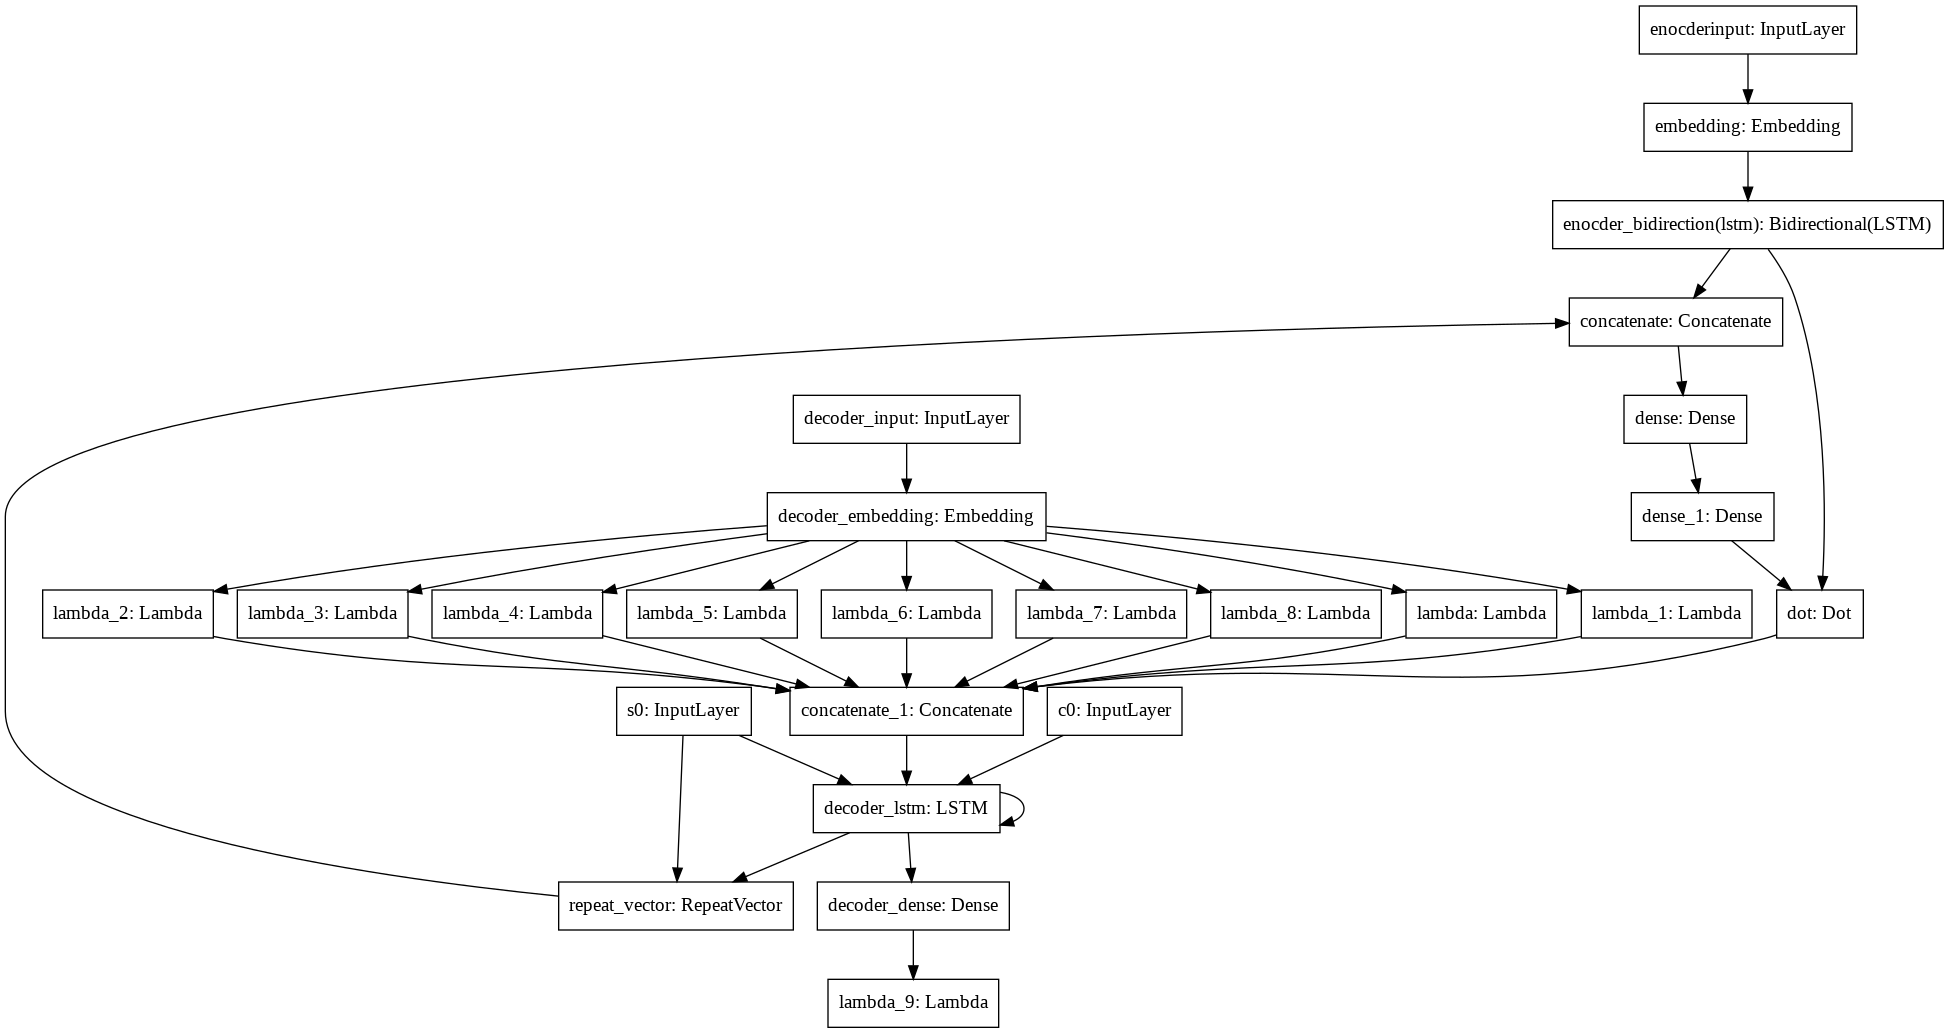

In [ ]:
tf.keras.utils.plot_model (model)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


Training

In [ ]:
initial_s_training=np.zeros((NUM_SAMPLES,LATENT_DIM)) #initial s c
initial_c_training =np.zeros(shape=(NUM_SAMPLES,LATENT_DIM))
r=model.fit([encoder_input_data,
             decoder_input_data,
             initial_s_training,
             initial_c_training],
            decoder_target_one_hot,
            batch_size=100,
            epochs=100,
            validation_split=0.3)

Epoch 1/100
70/70 [==============================] - 8s 119ms/step - loss: 3.4339 - accuracy: 0.5820 - val_loss: 2.9704 - val_accuracy: 0.5284
Epoch 2/100
70/70 [==============================] - 5s 72ms/step - loss: 2.3804 - accuracy: 0.6299 - val_loss: 2.8928 - val_accuracy: 0.5671
Epoch 3/100
70/70 [==============================] - 5s 72ms/step - loss: 2.2940 - accuracy: 0.6489 - val_loss: 2.8660 - val_accuracy: 0.5823
Epoch 4/100
70/70 [==============================] - 5s 73ms/step - loss: 2.2395 - accuracy: 0.6541 - val_loss: 2.8380 - val_accuracy: 0.5942
Epoch 5/100
70/70 [==============================] - 5s 73ms/step - loss: 2.1903 - accuracy: 0.6634 - val_loss: 2.7980 - val_accuracy: 0.6008
Epoch 6/100
70/70 [==============================] - 5s 72ms/step - loss: 2.1476 - accuracy: 0.6687 - val_loss: 2.7690 - val_accuracy: 0.6120
Epoch 7/100
70/70 [==============================] - 5s 70ms/step - loss: 2.1022 - accuracy: 0.6737 - val_loss: 2.7410 - val_accuracy: 0.6173
Epoch

# Encoder model

In [ ]:
encoder_model = Model(encoder_inputs, encoder_outputs)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enocderinput (InputLayer)    [(None, 5)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 5, 200)            466400    
_________________________________________________________________
enocder_bidirection (Bidirec (None, 5, 512)            935936    
Total params: 1,402,336
Trainable params: 1,402,336
Non-trainable params: 0
_________________________________________________________________


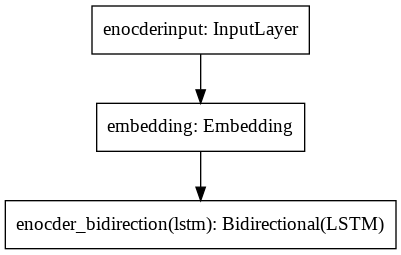

In [ ]:
tf.keras.utils.plot_model (encoder_model)

# Decoder Model

In [ ]:
#input will have the length double of latent dimension due to bidirectional
encoder_outputs_as_input = Input(shape=(maxlen_input, LATENT_DIM* 2,)) 
#we are going to predict one word at a time with input of one word
decoder_input_embedding = Input(shape=(1,))                
decoder_input_ = decoder_embedding(decoder_input_embedding) 

In [ ]:
#calculating context
context = context_attention(encoder_outputs_as_input, initial_s)

In [ ]:
decoder_lstm_input = context_last_word_concat_layer(
    [context, decoder_input_])

In [ ]:
out, s, c = decoder_lstm(decoder_lstm_input,                        
                       initial_state=[initial_s, initial_c]) 
decoder_outputs = decoder_dense(out) 

In [ ]:
decoder_model = Model(
  inputs=[
    decoder_input_embedding,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s0 (InputLayer)                 [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5, 512)]     0                                            
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 5, 256)       0           s0[0][0]                         
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 5, 768)       0           input_1[0][0]                    
                                                                 repeat_vector[9][0]        

In [ ]:
#tf.keras.utils.plot_model (decoder_model,to_file='decoder_model.jpg')
tf.keras.utils.plot_model (decoder_model)

# Translating

In [ ]:
word2index_input=tokenizer_in.word_index
word2index_output=tokenizer_out.word_index
#reverse mapping integer to words for english
idx2word_eng = {v:k for k, v in word2index_input.items()}  
#reverse mapping integer to words for spanish
idx2word_trans = {v:k for k, v in word2index_output.items()}  

In [ ]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq) 

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2index_output['<start>']

  # if we get this we break
  End_statement = word2index_output['<end>'] 

  # [s, c] will be updated in each loop iteration
  s = np.zeros((1,LATENT_DIM))
  c = np.zeros((1,LATENT_DIM))

  # Create the translation
  output_sentence = []
  for _ in range(maxlen_output):
    out, s, c = decoder_model.predict([target_seq, enc_out, s, c]) 
        
    # Get next word
    index = np.argmax(out.flatten()) 

    # End sentence
    if End_statement == index: 
      break

    word = ''
    if index > 0:
      word = idx2word_trans[index]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = index

  return ' '.join(output_sentence)

In [ ]:
count=0
while (count<5):
  
  input_text=[str(input('input the sentence : '))]
  seq=tokenizer_in.texts_to_sequences(input_text)
  
  input_seq=pad_sequences(seq,maxlen=maxlen_input,padding='post')
  translation=decode_sequence(input_seq)
  
  print('Predicted translation:', translation)
  count+=1

input the sentence : Hello
Predicted translation: hola
input the sentence : How are you?
Predicted translation: ¿qué están
input the sentence : What are you doing?
Predicted translation: ¿qué te te
input the sentence : see you later
Predicted translation: hasta vemos
input the sentence : bye
Predicted translation: ¡has
